In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

from beautifultable import BeautifulTable as BT
# import pandas_profiling

from matplotlib import rcParams
import warnings

from sklearn.model_selection import train_test_split as separar
from sklearn.preprocessing import MinMaxScaler

%matplotlib notebook
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,7)

In [2]:
#lectura de la data 
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [3]:
df.describe()
# cambio de tipo de dato de algunas variables
df['age'] = df['age'].astype(np.int64)
df['platelets'] = df['platelets'].astype(np.int64)
df['serum_creatinine'] = df['serum_creatinine'].astype(np.int64)

df.dtypes


profile = ProfileReport(df, title='Heart Failure', explorative=True, vars={"num": {"low_categorical_threshold": 0}} )
profile.to_file("tmp.html")
profile

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Los ceros corresponden a falsos y los unos a verdaderos
- edad: edad del paciente (años)
- anemia: disminución de glóbulos rojos o hemoglobina (booleana)
- presión arterial alta: si el paciente tiene hipertensión (booleano)
- creatinina fosfoquinasa (CPK): nivel de la enzima CPK en la sangre (mcg/L) valores muy lejanos, posibles outliers
- diabetes: si el paciente tiene diabetes (booleano)
- fracción de eyección: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- plaquetas: plaquetas en la sangre (kiloplaquetas/mL) posibles valores atipicos
- sexo: mujer u hombre (binario) (0 -> mujeres)
- creatinina sérica: nivel de creatinina sérica en la sangre (mg/dL)
- sodio sérico: nivel de sodio sérico en la sangre (mEq/L)
- smoking: si el paciente fuma o no (booleano)
- tiempo: período de seguimiento (días) podríamos normalizar
- Evento de muerte [objetivo]: si el paciente falleció durante el período de seguimiento (booleano)

La CPK es una enzima que se encuentra en el corazón, si se libera significa que las celular del corazón están muriendo y por eso esta en sangre y no en corazón, significa que hay falla cardíaca.

La fracción de eyeccion, es la cantidad de sangre que sale con cada latido del corazón, debe de salir en total unos 75 ml de sangre, si eso no sucede, significa que el corazón esta muy débil para contraerse con la suficiente fuerza para que salga toda esa sangre.

Las plaquetas son importantes antes de una cirugía, representa la facilidad con la que una persona podría sangrar al momento de entrar al quirofano, entre más baja las plaquetas, más riesgo de muerte por sangrado.

La creatinina, es por así decirlo, basura que genera los músculos cada vez que se mueven, esta es filtrada por los riñones, si esta elevada, significa que hay algún tipo falla renal.

Si todo estos valores están elevados, es más probable que una persona fallezca si le da algún infarto.

# Preparing data

In [4]:
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   75        0                       582         0                 20   
1   55        0                      7861         0                 38   
2   65        0                       146         0                 20   
3   50        1                       111         0                 20   
4   65        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1     265000                 1           130    1   
1                    0     263358                 1           136    1   
2                    0     162000                 1           129    1   
3                    0     210000                 1           137    1   
4                    0     327000                 2           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [5]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [6]:
#separación de variables booleanas y continuas
bool_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
cont_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

In [7]:
# características de la data
x = df.iloc[:,:-1]
# variable respuesta
y = df.iloc[:,-1]

In [8]:
#conjunto de train y test splitting
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = .25
                                                    )

In [9]:
#estandarizacion
def std_df(df_train, df_test, col:str):
    '''
    Esta funcion realiza una estandarizacion a las 
    variables continuas y devuelde el df con la columna 
    estandarizada
    
    '''
    avg = df_train[col].mean()
    #print(avg)
    des = df_train[col].std()
    #print(des)
    
    #crear copias para no alterar las variables originales
    df_train_sc = df_train.copy()
    df_test_sc  = df_test.copy()
    
    df_train_sc[col] = (df_train_sc[col] - avg) / des
    df_test_sc[col] = (df_test_sc[col] - avg) / des
    
    return df_train_sc[col], df_test_sc[col]

# transformacion booleana
def change_bool(df_train, df_test, col:str):
    '''
    Esta función cambia las variables binarias,
    donde había cero ahora se pone un -1
    
    esto para mejorar el rendimiento de las redes neuronales
    '''
    
    #crear copias para no alterar las variables originales
    df_train_sc = df_train.copy()
    df_test_sc  = df_test.copy()
    
    df_train_sc[col] = [1 if i == 1 else -1 for i in df_train[col]]
    df_test_sc[col]  = [1 if i == 1 else -1 for i in df_test[col]]
    
    return df_train_sc[col], df_test_sc[col]

**Nota:** Para mejorar el performance de los moedelos se ha decidido cambair las variables binarias, donde había cero ahora habrá -.1 y los unos se quedan tal cual

In [10]:
x_train_sc, x_test_sc = x_train.copy(), x_test.copy()

In [11]:
#estandarizacion de variables continuas
for i in cont_features:
    x_train_sc[i], x_test_sc[i] = std_df(x_train, x_test, i)

#transformacion de variables bianrias en -.1 cuando es cero y .1 cuando es 1
for i in bool_features:
    x_train_sc[i], x_test_sc[i] = change_bool(x_train, x_test, i)

# Naive Bayes

In [12]:
#se genera el constructor del modelo
classifier_nb = GaussianNB()
# se ajuste el modelo con el conjunto de train
classifier_nb.fit(x_train_sc, y_train)
# se hacen predicciones sobre el conjunto de test
y_preds_nb = classifier_nb.predict(x_test_sc)

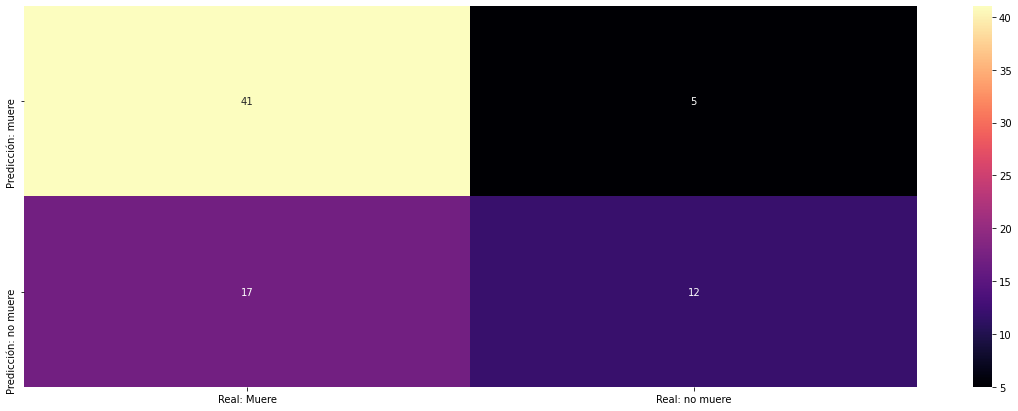

In [13]:
#generamos la matriz de confusion para ver el rendimiento del modelo
cm = confusion_matrix(y_test, y_preds_nb)

cm_matrix_nb = pd.DataFrame(data = cm, columns=['Real: Muere', 'Real: no muere'], 
                                 index=['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_nb, annot =True, cmap='magma', fmt='d');

In [14]:
#reporte de clasificacion en relación a las predicciones 
print(classification_report(y_test, y_preds_nb))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        46
           1       0.71      0.41      0.52        29

    accuracy                           0.71        75
   macro avg       0.71      0.65      0.66        75
weighted avg       0.71      0.71      0.69        75



In [15]:
#cross validation del modelo
scores = cross_val_score(classifier_nb, x_test, y_test, cv = 5, scoring='accuracy')
scores.mean()*100

72.0

El algoritmo de Naive Bayes es un algoritmo de clasificación y predicción supervisada basado en el Teorema de Bayes (teorema de la probabilidad condicionada), en este algoritmo se asume que las variables predictoras son independientes entre sí.
Lo que se intenta hacer en este algoritmo es saber la probabilidad de que ocurra un cierto evento dadas las probabilidades de que ocurran eventos anteriores.

#### Teorema de Bayes:
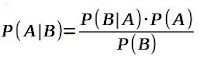

# Arbol de decision

In [16]:
# se genera el contructor del modelo
tree = DecisionTreeClassifier()
# se ajusta el modelo con la data de train
tree.fit(x_train_sc, y_train)
# se predice el modelo con la data de test
y_pred_test_tree = tree.predict(x_test_sc)

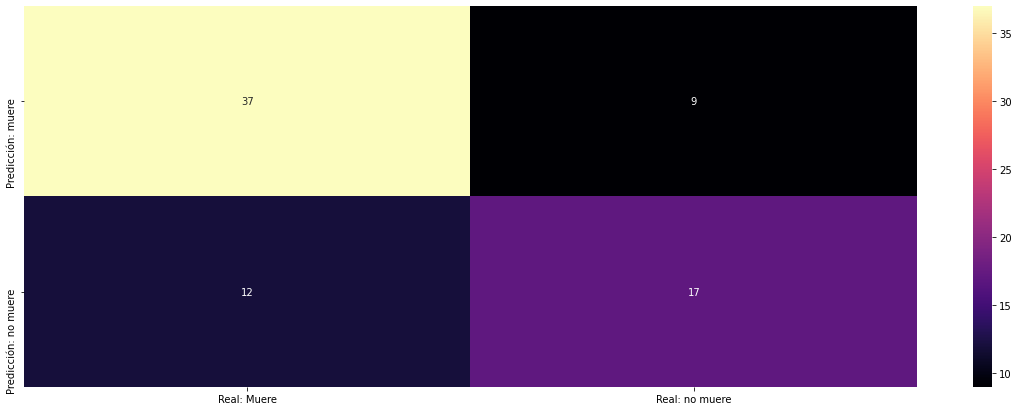

In [17]:
# se genera la matriz de confusion apra ver el rendimiento del algoritmo
cm = confusion_matrix(y_test, y_pred_test_tree)

cm_matrix_tree = pd.DataFrame(data = cm, columns = ['Real: Muere', 'Real: no muere'], 
                                 index = ['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_tree, annot =True, cmap='magma', fmt='d');

In [18]:
#reporte de predicciones del modelo
print(classification_report(y_test, y_pred_test_tree))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        46
           1       0.65      0.59      0.62        29

    accuracy                           0.72        75
   macro avg       0.70      0.70      0.70        75
weighted avg       0.72      0.72      0.72        75



In [19]:
#cross validation del modelo
scores = cross_val_score(tree, x_test, y_test, cv = 5, scoring = 'accuracy')
scores.mean()*100

73.33333333333334

Los árboles de decisión son algoritmos de aprendizaje supervisado que se utilizan para clasificación o regresión, tienen justo la estructura de un árbol, y en este diagrama cada nodo representa una característica, la rama es la regla de decisión y el "nodo hoja" es el resultado, la visualización de este diagrama ayuda a la toma de decisiones.

Este algoritmo resuelve el problema con la categorización de los atributos de manera sucesiva hasta tomar una decisión y llegar a la resolución.

#### Flujo de Árbol de decisión:
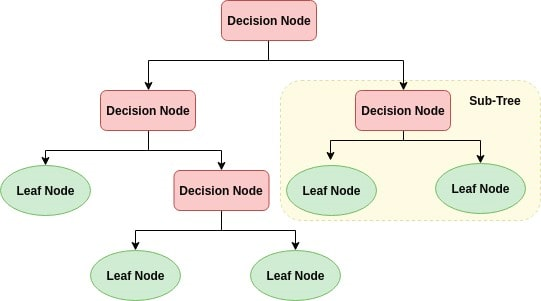


# Regresión logística

In [20]:
# se crea el constructor del modelo
LR_sc = LogisticRegression(C = 0.01, solver = 'liblinear')
# se ajusta el modelo con la data de train
LR_sc.fit(x_train_sc, y_train)
#predicciones con la data de test
y_pred_test_lr = LR_sc.predict(x_test_sc)

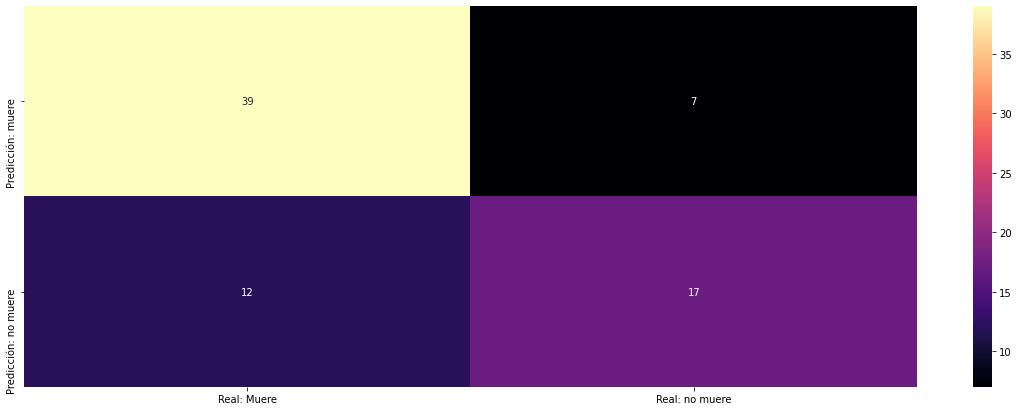

In [21]:
# matriz de confusion para ver el redimeinto del modelo
cm = confusion_matrix(y_test, y_pred_test_lr)

cm_matrix_lr = pd.DataFrame(data = cm, columns = ['Real: Muere', 'Real: no muere'], 
                                 index = ['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_lr, annot =True, cmap='magma', fmt='d');

In [22]:
# reporte de  las predicciones
print(classification_report(y_test, y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80        46
           1       0.71      0.59      0.64        29

    accuracy                           0.75        75
   macro avg       0.74      0.72      0.72        75
weighted avg       0.74      0.75      0.74        75



In [23]:
#cross validation del modelo
scores = cross_val_score(LR_sc, x_test_sc, y_test, cv = 5, scoring = 'accuracy')
scores.mean()*100

74.66666666666667

La regresión logística es un método de regresión que permite estimar una variable cualitativa binaria, el objetivo modelar como influyen las variables en la probabilidad de que ocurra un evento.

Tiene la misma estrategia que la Regresión Lineal Múltiple, la variable de respuesta no es continua, sino discreta (y como lo mencionamos, binaria), las variables independientes pueden ser cuantitativas o cualitativas (para el caso de las variables cualitativas se generan variables dummy dependiendo del número de categorías)

# Bosque Aleatorio

In [24]:
# Clasificador
classifier = RandomForestClassifier(n_estimators=100)
# Entrenamos con conjunto de entrenamiento
classifier.fit(x_train_sc, y_train) # x_train_n
#preds con el conjunto de test
y_pred_test_forest = classifier.predict(x_test_sc)

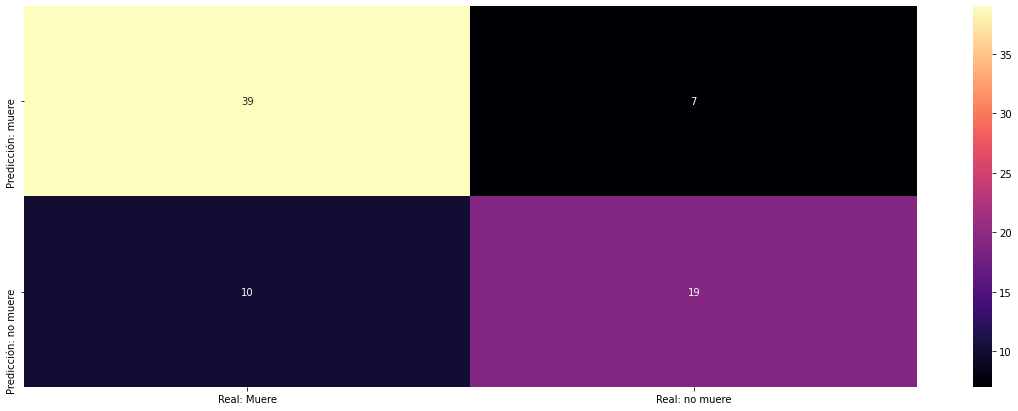

In [25]:
#matriz de confusion para ver el rendimiento del modelo
cm = confusion_matrix(y_test, y_pred_test_forest)

cm_matrix_forest = pd.DataFrame(data = cm, columns = ['Real: Muere', 'Real: no muere'], 
                                 index = ['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_forest, annot =True, cmap='magma', fmt='d');

In [26]:
print(classification_report(y_test, y_pred_test_forest))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        46
           1       0.73      0.66      0.69        29

    accuracy                           0.77        75
   macro avg       0.76      0.75      0.76        75
weighted avg       0.77      0.77      0.77        75



In [27]:
# cross validation del modelo 
scores = cross_val_score(classifier, x_test_sc, y_test, cv = 5, scoring = 'accuracy')
scores.mean()*100

76.0

In [28]:
# Catacterísticas importantes
feature_importances_df = pd.DataFrame(
    {"feature": list(x_train_sc.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

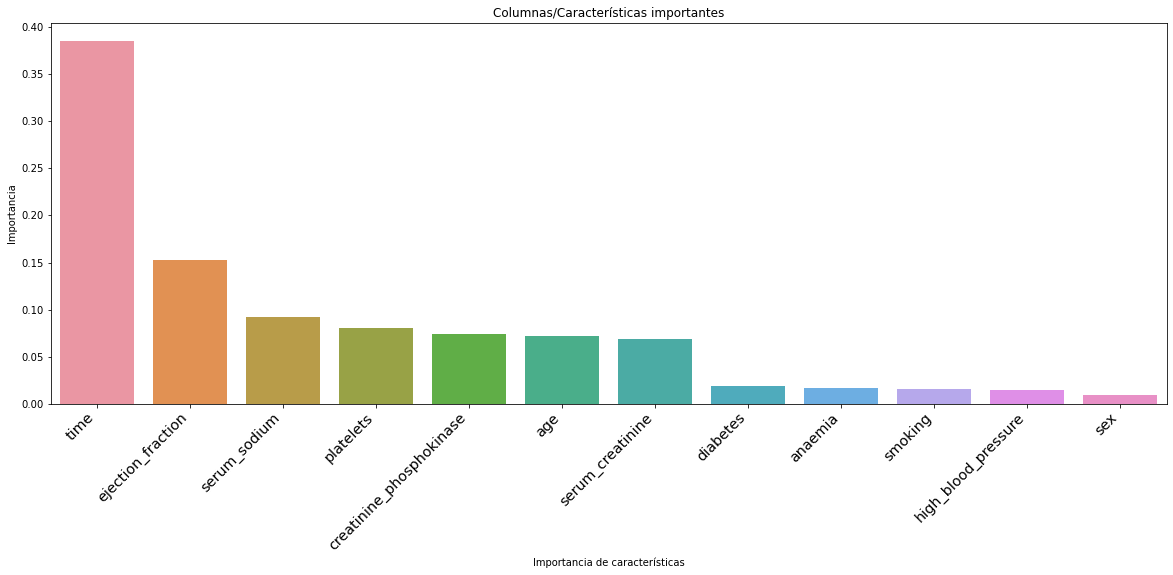

feature  importance
11                      time    0.384984
4          ejection_fraction    0.153111
8               serum_sodium    0.091729
6                  platelets    0.080792
2   creatinine_phosphokinase    0.073538
0                        age    0.072374
7           serum_creatinine    0.068924
3                   diabetes    0.018399
1                    anaemia    0.016622
10                   smoking    0.015773
5        high_blood_pressure    0.014744
9                        sex    0.009010

In [29]:
# Plot características importantes

# Gráfica de barras
sns.barplot(x = feature_importances_df.feature, y = feature_importances_df.importance)


plt.xlabel("Importancia de características")
plt.ylabel("Importancia")
plt.title("Columnas/Características importantes")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()
feature_importances_df

El sexo influye en las muertes????, podemos notar que no es un factor relevante

In [30]:
df[df['sex'] == 0]['DEATH_EVENT'].value_counts()

0    71
1    34
Name: DEATH_EVENT, dtype: int64

In [31]:
df[df['sex'] == 1]['DEATH_EVENT'].value_counts()

0    132
1     62
Name: DEATH_EVENT, dtype: int64

El bosque aleatorio combina cientos de árboles de decisión y los entrena con una muestra aleatoria y diferente de los datos (ningún árbol trabaja con todos los datos de entrenamiento), para obtener el resultado final se "vota" sobre las predicciones de los árboles, las diferencias con los árboles es que a veces los árboles tienden a sobreajustar, pero en el bosque se puede mitigar el problema tomando la "votación" de los resultados de predicción de los diferentes árboles.

La parte de la votación depende del tipo de problema a resolver, si es un problema de clasificación la votación es tomar la moda de las predicciones de los árboles (o también se le llama el voto suave), y para un problema de regresión se toma la media de las predicciones 

#### Bosque aleatorio

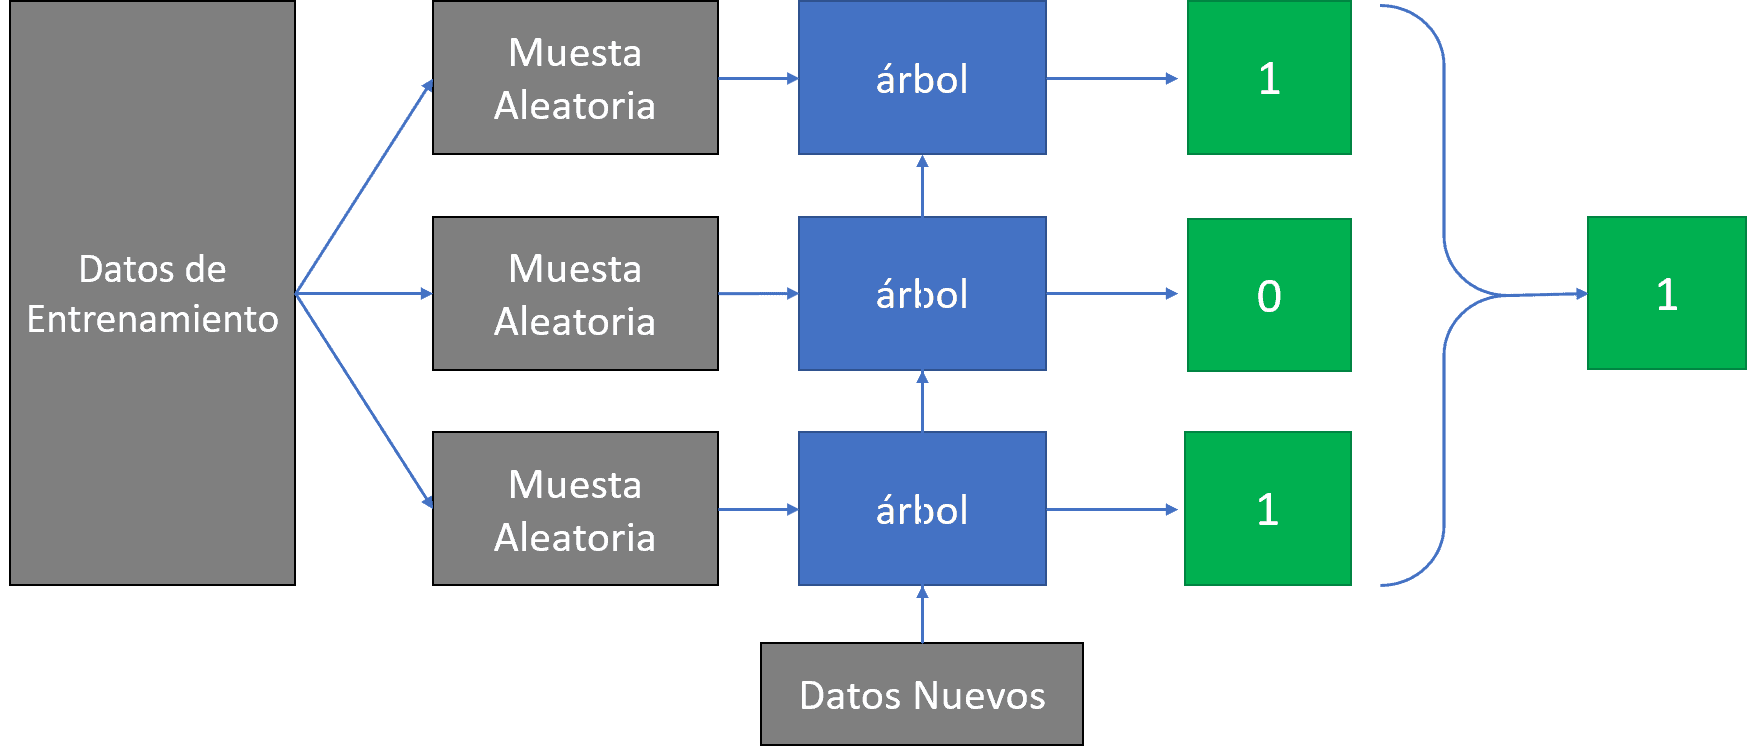

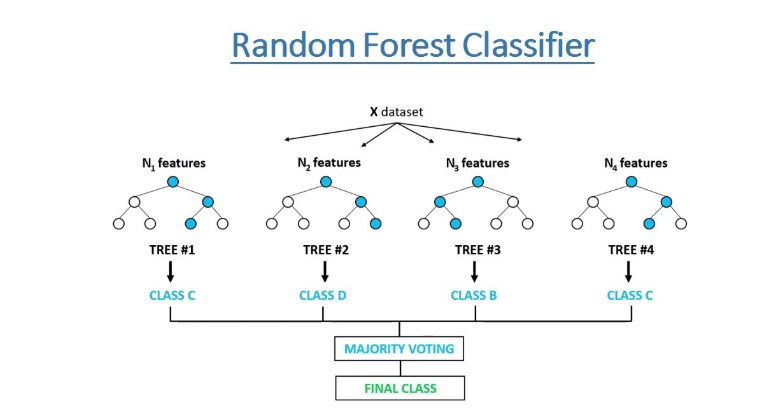

# Preprocesamiento de datos para la red

# Red neuronal simple

In [55]:
def build_model():
    model = keras.Sequential([
        #capas densas
        layers.Dense(24, activation = "relu"),
        layers.Dense(48, activation = "relu"),
        #layers.Dense(4, activation = "relu"), # cuello de botella 
        #quitar el 4 y poner 12
        layers.Dense(1, activation = 'sigmoid') #activación sigmoide para la clasificacion
    ])
    model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.1), 
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [56]:
m_1 = build_model()

callbacks = [
    keras.callbacks.ModelCheckpoint( #revisa la perdida
        filepath = "convnet_from_scratch.keras",
        save_best_only = True, #guarda el mejor modelo
        monitor = "val_loss") #monitoreal eval loss
]
#enytrenamiento de la red con la data de train
red_simple = m_1.fit(x_train_sc, 
        y_train,
        epochs = 50, 
        batch_size = 13,
        validation_split = 0.2,
        callbacks = callbacks
        )

Epoch 1/50
14/14 [==============================] - 2s 33ms/step - loss: 1.2853 - accuracy: 0.6983 - val_loss: 0.5108 - val_accuracy: 0.8000
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 0.5597 - accuracy: 0.7821 - val_loss: 0.2642 - val_accuracy: 0.9333
Epoch 3/50
14/14 [==============================] - 0s 10ms/step - loss: 0.4802 - accuracy: 0.8212 - val_loss: 0.7852 - val_accuracy: 0.7556
Epoch 4/50
14/14 [==============================] - 0s 14ms/step - loss: 0.5764 - accuracy: 0.8045 - val_loss: 0.2186 - val_accuracy: 0.9111
Epoch 5/50
14/14 [==============================] - 0s 10ms/step - loss: 0.4104 - accuracy: 0.8212 - val_loss: 0.3011 - val_accuracy: 0.9333
Epoch 6/50
14/14 [==============================] - 0s 10ms/step - loss: 0.4168 - accuracy: 0.7933 - val_loss: 0.3195 - val_accuracy: 0.8889
Epoch 7/50
14/14 [==============================] - 0s 10ms/step - loss: 0.4792 - accuracy: 0.7542 - val_loss: 1.3522 - val_accuracy: 0.7778
Epoch 8/50
14

In [57]:
#resumen del modelo
m_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                312       
                                                                 
 dense_7 (Dense)             (None, 48)                1200      
                                                                 
 dense_8 (Dense)             (None, 4)                 196       
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,713
Trainable params: 1,713
Non-trainable params: 0
_________________________________________________________________


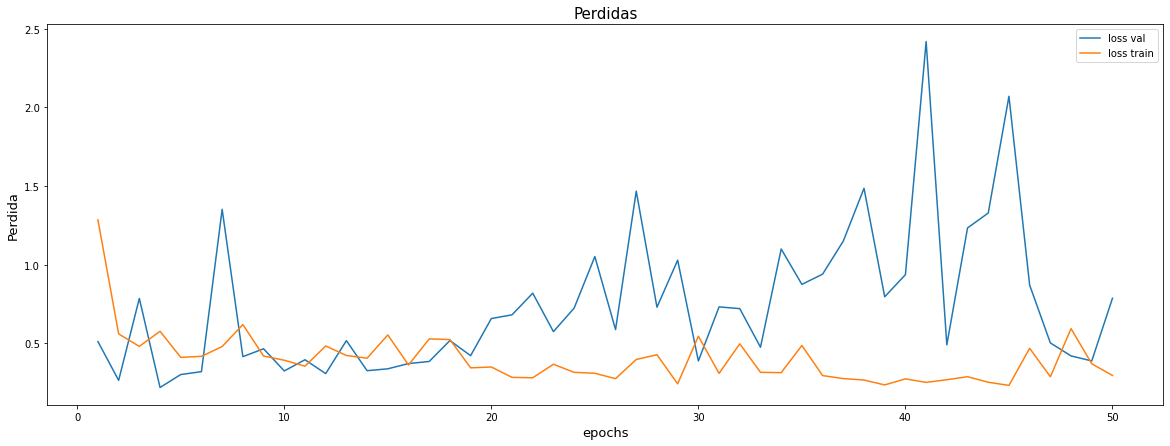

In [58]:
# grafica de la perdida de train y validacion
loss_val = red_simple.history['val_loss']
loss_train = red_simple.history['loss']

epochs = range(1, 51)

plt.plot(epochs, loss_val, label = "loss val")
plt.plot(epochs, loss_train, label = "loss train")

plt.title("Perdidas",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Perdida",fontsize=13)
plt.legend()
plt.show()

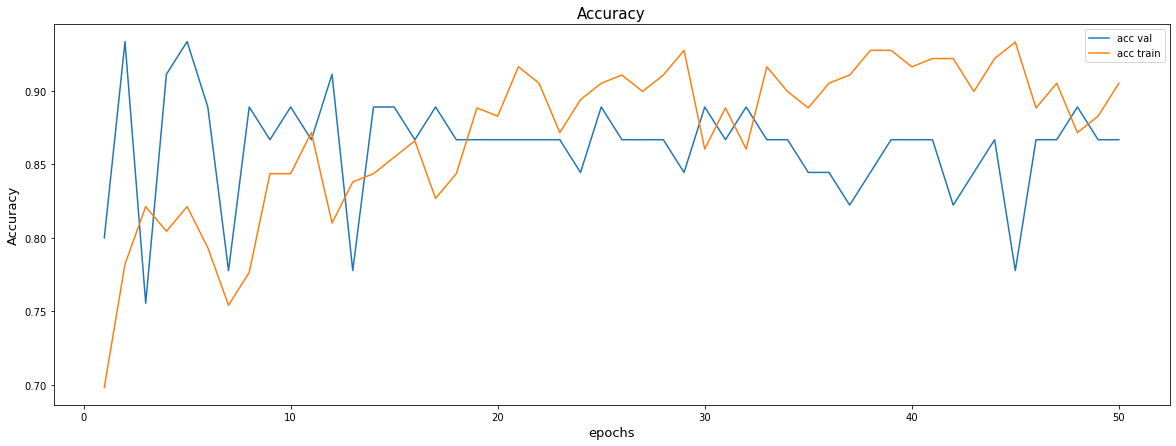

In [59]:
#grafica del accuracy de entrenamiento y validacion
acc_val = red_simple.history['val_accuracy']
acc_train = red_simple.history['accuracy']

epochs = range(1, 51)

plt.plot(epochs, acc_val, label = "acc val")
plt.plot(epochs, acc_train, label = "acc train")

plt.title("Accuracy",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()

In [60]:
#predicciones de la red
predictions = m_1.predict(x_test_sc)
#identifico las mayores a 0.5
a = predictions > 0.5
# identifico los que son iguales a 1 en la data oroginal
b = y_test == 1

#reshapeo el arreglo a
a = a.reshape(75 ,)
# luego, comparo los valores verdaderos (variable b) con 
# las predicciones (variable a)
c = (a == b)
#conteo de verdaderos y falsos y proporcion de aciertos
c.value_counts(), c.value_counts()[1] / (c.value_counts()[1] + c.value_counts()[0])

(True     51
 False    24
 Name: DEATH_EVENT, dtype: int64,
 0.68)

In [61]:
# genero arreglo de predicciones
red_simple_preds = [1 if i > 0.5 else 0 for i in predictions]

In [62]:
#reporte de clasificacion con las preds de la red
print(classification_report(y_test, red_simple_preds))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        46
           1       0.65      0.38      0.48        29

    accuracy                           0.68        75
   macro avg       0.67      0.62      0.62        75
weighted avg       0.67      0.68      0.66        75



# Matando Moscas con una bomba atómica?

### Preprocesamiento de datos para usarlos de forma matricial

In [40]:
# reshape de la data para meterla a un modelo de redes neuronales convolucionales

#conjunto de ytrain
x_train_net = []
for i in range(len(x_train_sc)):
    x_train_net.append(np.array(x_train_sc)[i].reshape(3,4))
    
#conjunto de test
x_test_net = []
for i in range(len(x_test_sc)):
    x_test_net.append(np.array(x_test_sc)[i].reshape(3,4))

In [41]:
# forma que tienen los conjuntos de train y test
x_train_net = np.array(x_train_net)
print(x_train_net.shape)
#test
x_test_net = np.array(x_test_net)
print(x_test_net.shape)

(224, 3, 4)
(75, 3, 4)


# Red sin Max pooling

In [42]:
inputs = keras.Input(shape=(3, 4, 1))
# red convolucional de 3 capas y con drop out
# spatial drop out en lugar de drop out
x = layers.Conv2D(filters = 24, kernel_size = 2, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 48, kernel_size = 1, activation="relu")(x)
x = layers.Dropout(0.2)(x) # se moldificó el drop-out porque la red no rendía bien
x = layers.Conv2D(filters = 24, kernel_size = 2, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 2, kernel_size = 1, activation="relu")(x) #cuello de botella
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_no_max_pool = keras.Model(inputs = inputs, outputs = outputs)

In [43]:
model_no_max_pool.compile(optimizer = 'rmsprop',
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint( #revisa la perdida
        filepath = "convnet_from_scratch.keras",
        save_best_only = True, #guarda el mejor modelo
        monitor = "val_loss") #monitoreal eval loss
]


history_no_max_pool = model_no_max_pool.fit(x_train_net, 
                      y_train, 
                      epochs = 100, 
                      batch_size = 13,
                      validation_split = 0.2,
                      callbacks = callbacks                     
                                           )

Epoch 1/100
14/14 [==============================] - 3s 64ms/step - loss: 0.6681 - accuracy: 0.6760 - val_loss: 0.6076 - val_accuracy: 0.7778
Epoch 2/100
14/14 [==============================] - 0s 24ms/step - loss: 0.6608 - accuracy: 0.6872 - val_loss: 0.5796 - val_accuracy: 0.7778
Epoch 3/100
14/14 [==============================] - 0s 23ms/step - loss: 0.6333 - accuracy: 0.6816 - val_loss: 0.5637 - val_accuracy: 0.7778
Epoch 4/100
14/14 [==============================] - 0s 25ms/step - loss: 0.6128 - accuracy: 0.6816 - val_loss: 0.5496 - val_accuracy: 0.7778
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6487 - accuracy: 0.6816 - val_loss: 0.5535 - val_accuracy: 0.7778
Epoch 6/100
14/14 [==============================] - 0s 22ms/step - loss: 0.6203 - accuracy: 0.6816 - val_loss: 0.5429 - val_accuracy: 0.7778
Epoch 7/100
14/14 [==============================] - 0s 24ms/step - loss: 0.6175 - accuracy: 0.6816 - val_loss: 0.5406 - val_accuracy: 0.7778
Epoch 

In [44]:
model_no_max_pool.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 4, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 24)          120       
                                                                 
 dropout (Dropout)           (None, 2, 3, 24)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 3, 48)          1200      
                                                                 
 dropout_1 (Dropout)         (None, 2, 3, 48)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 2, 24)          4632      
                                                                 
 dropout_2 (Dropout)         (None, 1, 2, 24)          0     

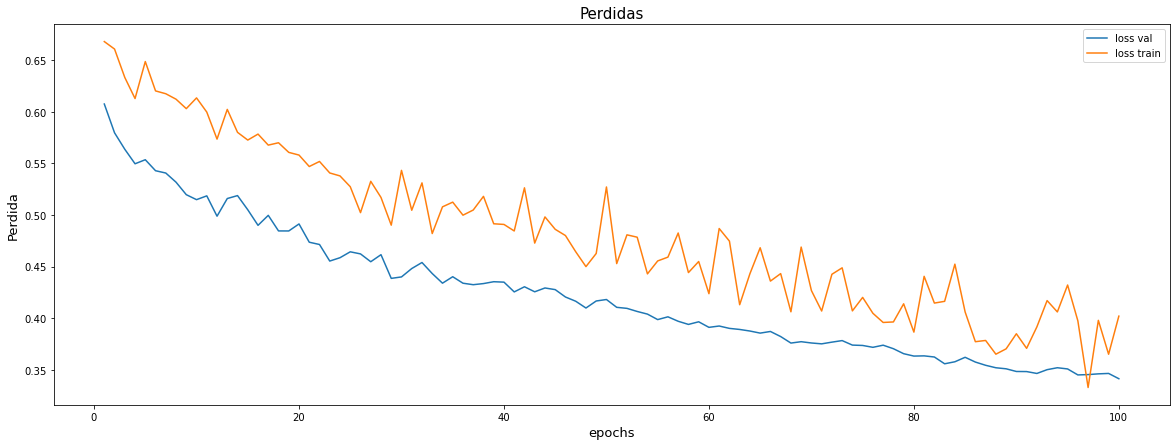

In [45]:
loss_val = history_no_max_pool.history['val_loss']
loss_train = history_no_max_pool.history['loss']

epochs = range(1, 101)

plt.plot(epochs, loss_val, label = "loss val")
plt.plot(epochs, loss_train, label = "loss train")

plt.title("Perdidas",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Perdida",fontsize=13)
plt.legend()
plt.show()

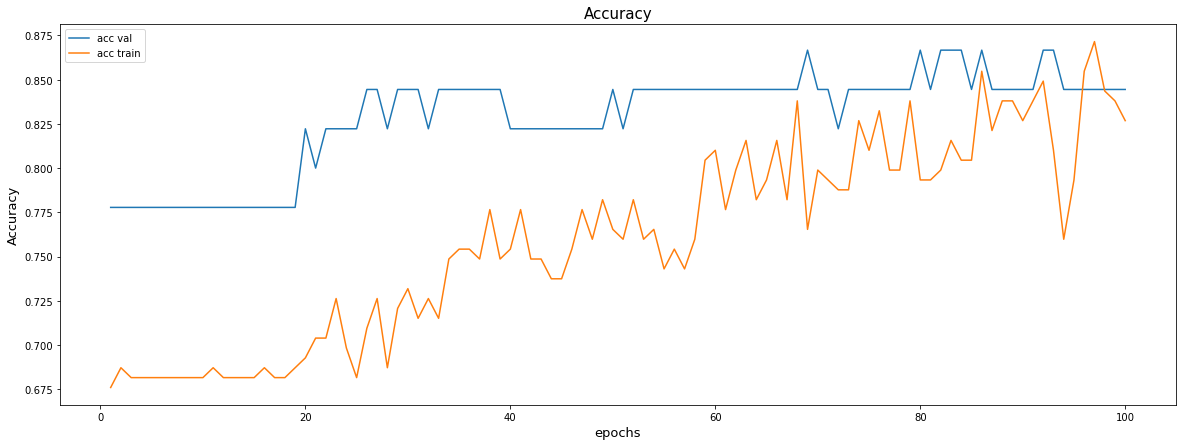

In [46]:
acc_val = history_no_max_pool.history['val_accuracy']
acc_train = history_no_max_pool.history['accuracy']

epochs = range(1, 101)

plt.plot(epochs, acc_val, label = "acc val")
plt.plot(epochs, acc_train, label = "acc train")

plt.title("Accuracy",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()

In [47]:
# predicciones con el conjunto de test
pred_no_max_pool = model_no_max_pool.predict(x_test_net)
# encontrando los valores predichos
red_no_max = [1 if i > 0.5 else 0 for i in pred_no_max_pool]
# reporte de clasificacion
print(classification_report(y_test, red_no_max))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        46
           1       0.68      0.59      0.63        29

    accuracy                           0.73        75
   macro avg       0.72      0.71      0.71        75
weighted avg       0.73      0.73      0.73        75



# Red con Max pooling

Un kernel de tamaño uno (tamaña de filtro) un kernel de tamaño uno no le hace nada a los datos, el Kernel comun es uno de tamaño 2

El max pooling extrae caracteristicas de la imagen (extrae el pixel maximo (promedio u otro) ), un max poolin de 2 disminuye la imagen en 2 dimensiones de lado

si la originas es de 3x4 y el maxpooling de 2 le quito toda la orilla 

- padding deja la imagen del tamaño original 

insertar padding en cada lote

In [48]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("vertical"), #voltear la foto
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2), #rotar la foto
        layers.RandomZoom(0.4), #ponerle zoom a la foto
    ]
)

En lugar de data augmantation hacer smothing

In [49]:
# definicion de tamaño de las imagenes
inputs = keras.Input(shape = (3, 4, 1))

#como tenemos poca data hacemos data_augmentation
x = data_augmentation(inputs)

#el padding mantiene nuestra matriz del mismo
# kernel size es la vision de la convolucion
#el stride son los pasos con los que se recorrer el filtro
x = layers.Conv2D(filters = 24, kernel_size = 2, padding = 'same', strides = 2, activation = "relu")(inputs)
x = layers.MaxPooling2D(pool_size = 2)(x)
#x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters = 48, kernel_size = 2, padding = 'same', strides = 2, activation = "relu")(x) 
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters = 24, kernel_size = 2, padding = 'same', strides = 2, activation = "relu")(x)
#x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters = 2, kernel_size = 1, activation = "relu")(x)

x = layers.Flatten()(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)
model_pool = keras.Model(inputs = inputs, outputs = outputs)

In [50]:
model_pool.compile(optimizer = 'rmsprop',
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

m_pool = model_pool.fit(x_train_net, 
                        y_train, 
                        epochs = 70, 
                        batch_size = 13,
                        validation_split = 0.2,
                        callbacks = callbacks
                       )

Epoch 1/70
14/14 [==============================] - 3s 42ms/step - loss: 0.6706 - accuracy: 0.6872 - val_loss: 0.6391 - val_accuracy: 0.7778
Epoch 2/70
14/14 [==============================] - 0s 14ms/step - loss: 0.6462 - accuracy: 0.6872 - val_loss: 0.5948 - val_accuracy: 0.7778
Epoch 3/70
14/14 [==============================] - 0s 13ms/step - loss: 0.6272 - accuracy: 0.6816 - val_loss: 0.5739 - val_accuracy: 0.7778
Epoch 4/70
14/14 [==============================] - 0s 13ms/step - loss: 0.6072 - accuracy: 0.7039 - val_loss: 0.5567 - val_accuracy: 0.7778
Epoch 5/70
14/14 [==============================] - 0s 12ms/step - loss: 0.5988 - accuracy: 0.6816 - val_loss: 0.5502 - val_accuracy: 0.7778
Epoch 6/70
14/14 [==============================] - 0s 13ms/step - loss: 0.5725 - accuracy: 0.7039 - val_loss: 0.5503 - val_accuracy: 0.7778
Epoch 7/70
14/14 [==============================] - 0s 12ms/step - loss: 0.5611 - accuracy: 0.7263 - val_loss: 0.5318 - val_accuracy: 0.7778
Epoch 8/70
14

In [51]:
model_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 4, 1)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 24)          120       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 24)         0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 48)          4656      
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 24)          4632      
                                                           

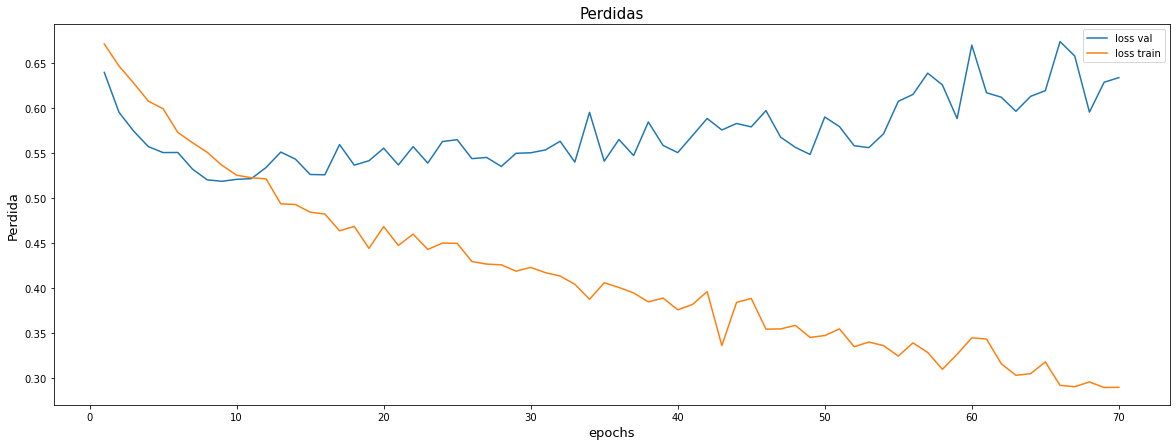

In [52]:
loss_val = m_pool.history['val_loss']
loss_train = m_pool.history['loss']

epochs = range(1, 71)

plt.plot(epochs, loss_val, label = "loss val")
plt.plot(epochs, loss_train, label = "loss train")

plt.title("Perdidas",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Perdida",fontsize=13)
plt.legend()
plt.show()

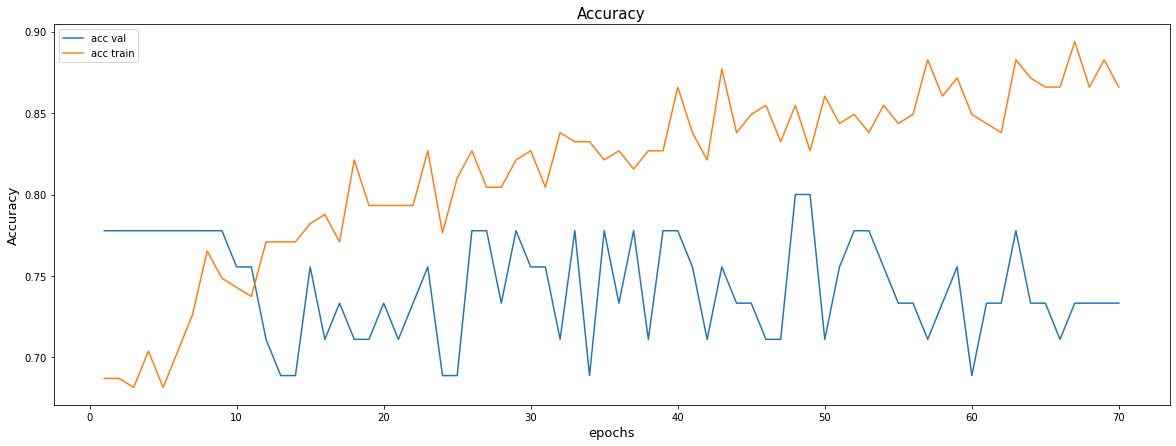

In [53]:
acc_val = m_pool.history['val_accuracy']
acc_train = m_pool.history['accuracy']

epochs = range(1, 71)

plt.plot(epochs, acc_val, label = "acc val")
plt.plot(epochs, acc_train, label = "acc train")

plt.title("Accuracy",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()

In [54]:
pred_max_pool = model_pool.predict(x_test_net)
red_max_pool = [1 if i > 0.5 else 0 for i in pred_max_pool]
print(classification_report(y_test, red_max_pool))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        46
           1       0.71      0.52      0.60        29

    accuracy                           0.73        75
   macro avg       0.73      0.69      0.70        75
weighted avg       0.73      0.73      0.72        75

